In [122]:
#IMPORT THE PACKAGES
import os, keras, cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers, losses, callbacks, activations, regularizers, metrics, applications, optimizers

In [123]:
#LOAD THE DATA
data = os.path.join(os.getcwd(),'dataset')
BATCH_SIZE = 10
IMG_SIZE = (160, 160)
train_d, val_d = keras.utils.image_dataset_from_directory(data,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          validation_split=0.3,
                                                          subset='both',
                                                          seed=42)

Found 3823 files belonging to 8 classes.
Using 2677 files for training.
Using 1146 files for validation.


['Blazer', 'Denim_Jacket', 'Hoodie', 'Jeans', 'Shorts', 'T shirt', 'button_shirts', 'long_pants']


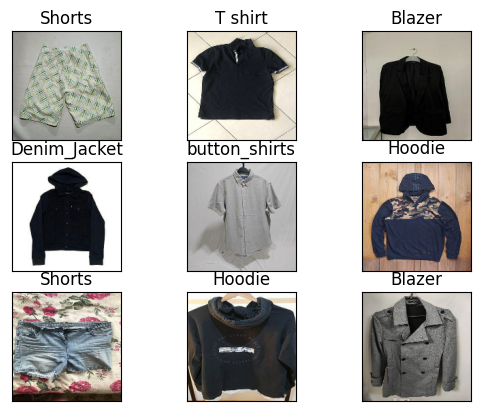

In [124]:
#plot the images
class_names = train_d.class_names
print(class_names)
batch_1 = train_d.take(1)
for feature, label in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.show()

In [125]:
#Convert the val dataset back to PrefetchDataset
val_d = val_d.prefetch(buffer_size=tf.data.AUTOTUNE)

In [126]:
#Create a sequential model for augmentation
data_aug = keras.Sequential()
data_aug.add(layers.RandomFlip())
data_aug.add(layers.RandomRotation(factor=0.2))

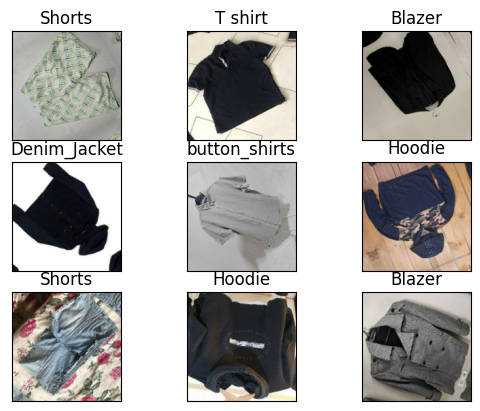

In [127]:
# Test feature augmentation
feature_augmented = data_aug(feature)
for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature_augmented[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
plt.show()

In [128]:
# Create the preprocessing layer based on the pretrained model that we will use
preprocess_input = applications.mobilenet_v2.preprocess_input

In [129]:
# apply transfer learning using pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# freeze the feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [130]:
# construct classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names), activation='softmax')

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_6 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_6 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

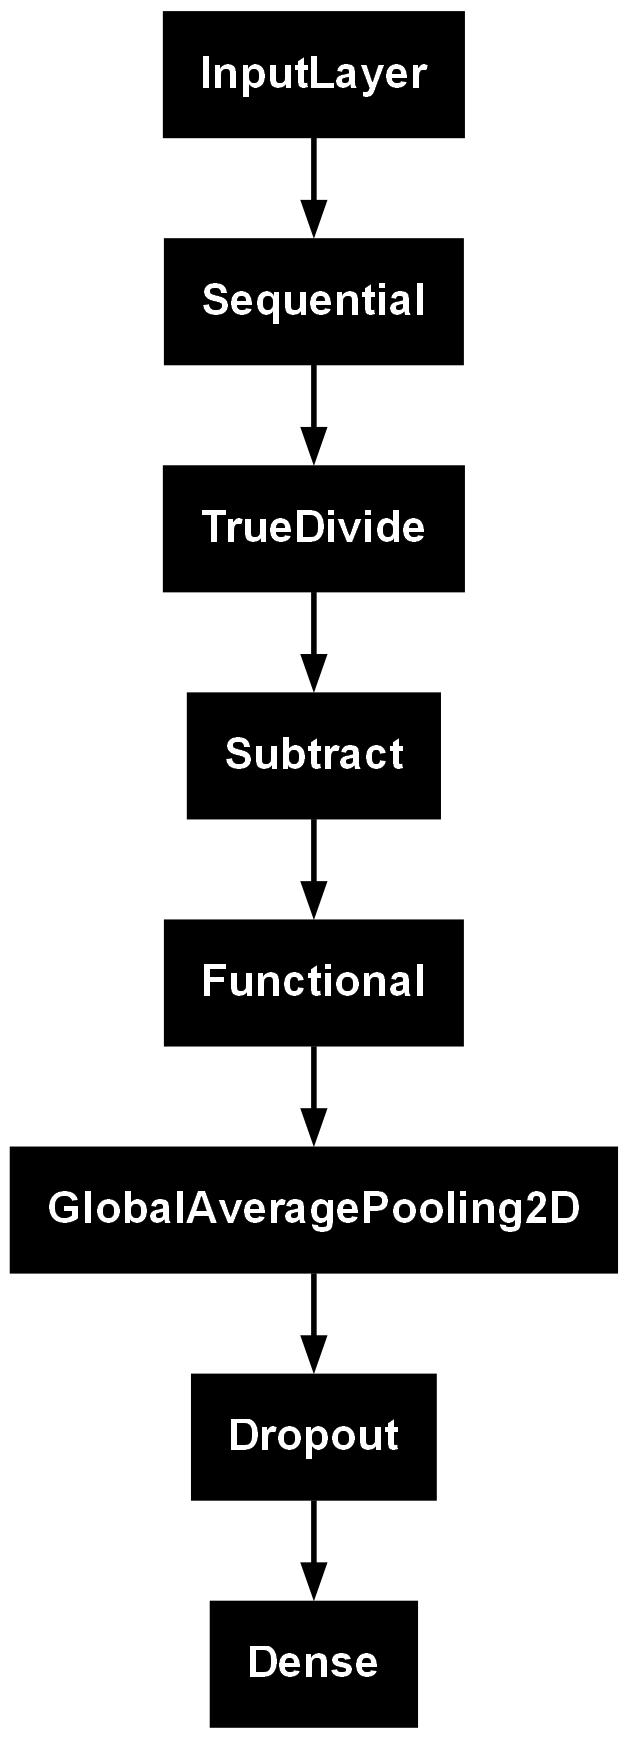

In [131]:
# use functional api to connect all layers
inputs = keras.Input(shape=IMG_SHAPE)
# augmentation layers
x = data_aug(inputs)
# preprocessing layer
x = preprocess_input(x)
# feature extractor
x = base_model(x)
# classifier
x = global_avg(x)
x = keras.layers.Dropout(rate=0.3)(x)
outputs = output_layer(x)
# create model
model = keras.Model(inputs = inputs, outputs= outputs)
model.summary()
keras.utils.plot_model(model=model)

In [132]:
# compile model
optimizer = optimizers.Adam(learning_rate=0.001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer= optimizer, loss=loss, metrics=['accuracy'])

In [133]:
# train model
stop = keras.callbacks.EarlyStopping(patience=4,verbose=1,start_from_epoch=5)
epochs = 25
history_first = model.fit(train_d, validation_data=val_d, epochs=epochs,callbacks=stop)

Epoch 1/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.3878 - loss: 1.7213 - val_accuracy: 0.7208 - val_loss: 0.8200
Epoch 2/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.6747 - loss: 0.9126 - val_accuracy: 0.7600 - val_loss: 0.6823
Epoch 3/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7192 - loss: 0.8008 - val_accuracy: 0.7801 - val_loss: 0.6138
Epoch 4/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7459 - loss: 0.7490 - val_accuracy: 0.7792 - val_loss: 0.6101
Epoch 5/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.7394 - loss: 0.7029 - val_accuracy: 0.7784 - val_loss: 0.6272
Epoch 6/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.7563 - loss: 0.6952 - val_accuracy: 0.7880 - val_loss: 0.6127
Epoch 7/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.7687 - loss: 0.6661 - val_accuracy: 0.7853 - val_loss: 0.6056
Epoch 8/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.7680 - loss: 0.6608 - 

In [134]:
# Evaluate the model after the first stage training
model.evaluate(val_d)

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7876 - loss: 0.6216


[0.6013124585151672, 0.7888306975364685]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
['long_pants', 'button_shirts', 'T shirt', 'Blazer', 'long_pants', 'Blazer', 'button_shirts', 'Denim_Jacket', 'T shirt', 'Jeans']


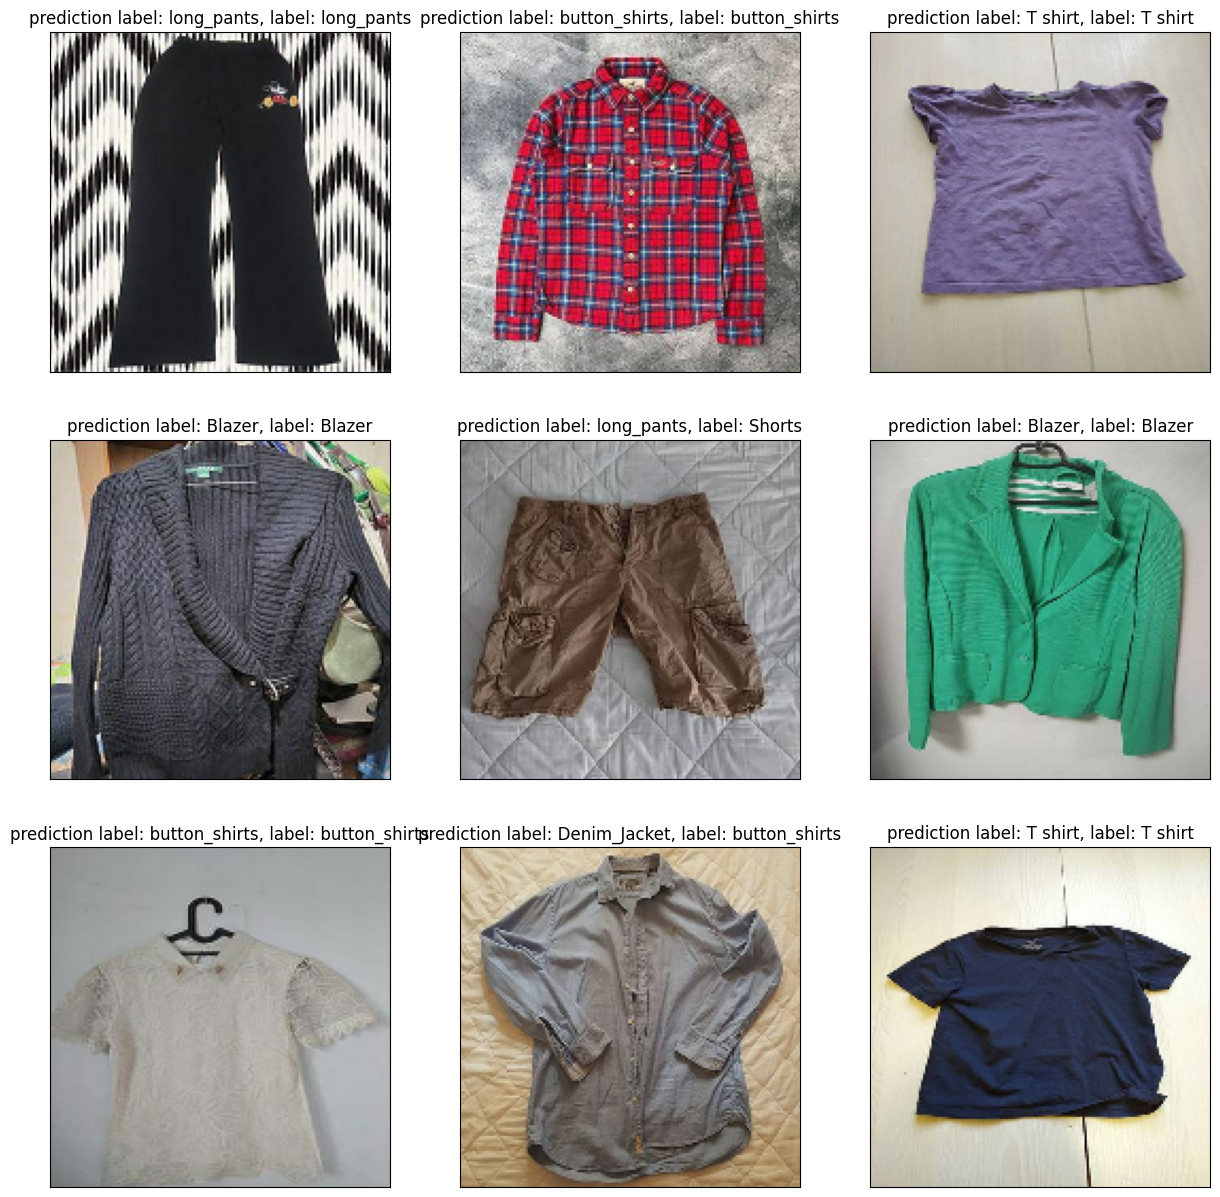

In [135]:
#make a prediction
for image_batch, label_batch in val_d.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'prediction label: {predicted_class[i]}, label: {class_names[label_batch[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [136]:
# 2nd stage transfer learning
# unfreeze model
base_model.trainable = True
# free earlier model of the base model
finetune_at = 100
for layer in base_model.layers[:finetune_at]:
    layer.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [137]:

second_epochs = 40
total_epochs = epochs + second_epochs
starting_epoch = history_first.epoch[-1] + 1
history_second = model.fit(train_d, validation_data=val_d, epochs=total_epochs, batch_size=BATCH_SIZE, initial_epoch=starting_epoch)


Epoch 14/65
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7708 - loss: 0.6293 - val_accuracy: 0.7958 - val_loss: 0.5803
Epoch 15/65
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.8074 - loss: 0.5641 - val_accuracy: 0.7941 - val_loss: 0.6136
Epoch 16/65
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.7877 - loss: 0.6103 - val_accuracy: 0.8045 - val_loss: 0.5890
Epoch 17/65
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7909 - loss: 0.5882 - val_accuracy: 0.8098 - val_loss: 0.5786
Epoch 18/65
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.7956 - loss: 0.5773 - val_accuracy: 0.8002 - val_loss: 0.5787
Epoch 19/65
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8054 - loss: 0.6065 - val_accuracy: 0.8019 - val_loss: 0.6051
Epoch 20/65
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.8164 - loss: 0.5250 - val_accuracy: 0.8002 - val_loss: 0.5994
Epoch 21/65
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.7956 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
['long_pants', 'button_shirts', 'T shirt', 'Blazer', 'long_pants', 'Blazer', 'button_shirts', 'Denim_Jacket', 'T shirt', 'Jeans']


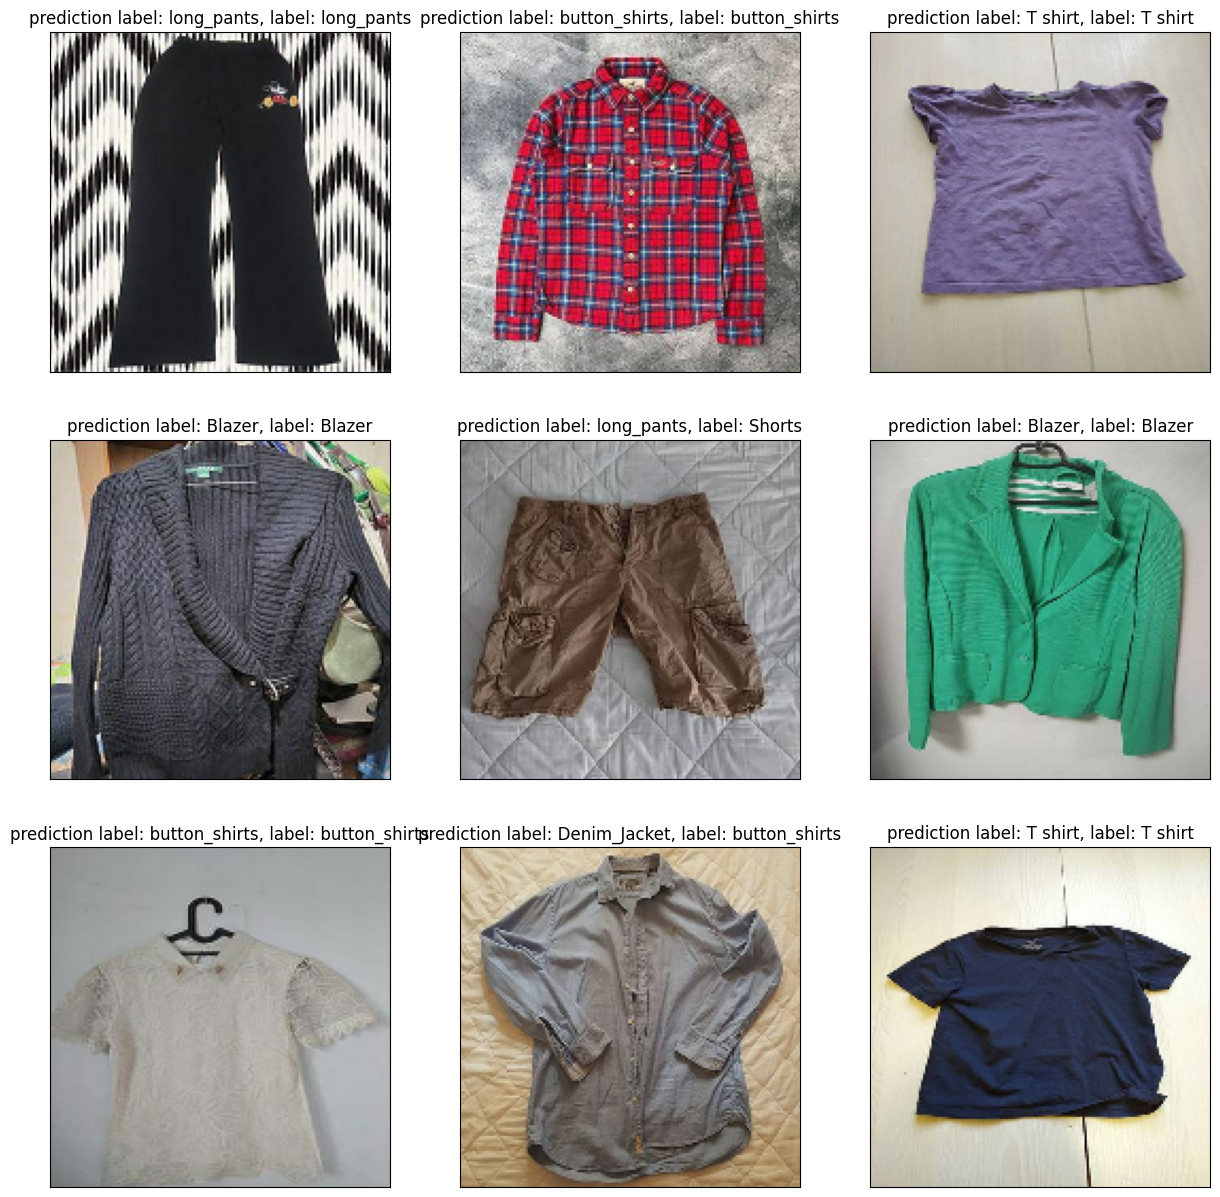

In [138]:
#make a prediction
for image_batch, label_batch in val_d.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'prediction label: {predicted_class[i]}, label: {class_names[label_batch[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

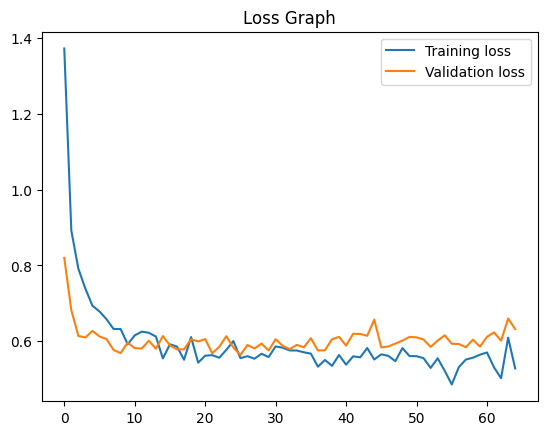

In [139]:
plt.plot(history_first.history['loss']+history_second.history['loss'])
plt.plot(history_first.history['val_loss']+history_second.history['val_loss'])
plt.title('Loss Graph')
plt.legend(['Training loss','Validation loss'])
plt.show()

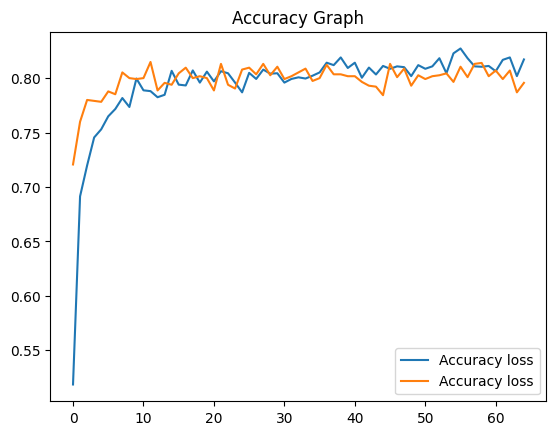

In [140]:
plt.plot(history_first.history['accuracy']+ history_second.history['accuracy'])
plt.plot(history_first.history['val_accuracy']+history_second.history['val_accuracy'])
plt.title('Accuracy Graph')
plt.legend(['Accuracy loss','Accuracy loss'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
['long_pants', 'button_shirts', 'T shirt', 'Blazer', 'long_pants', 'Blazer', 'button_shirts', 'Denim_Jacket', 'T shirt', 'Jeans']


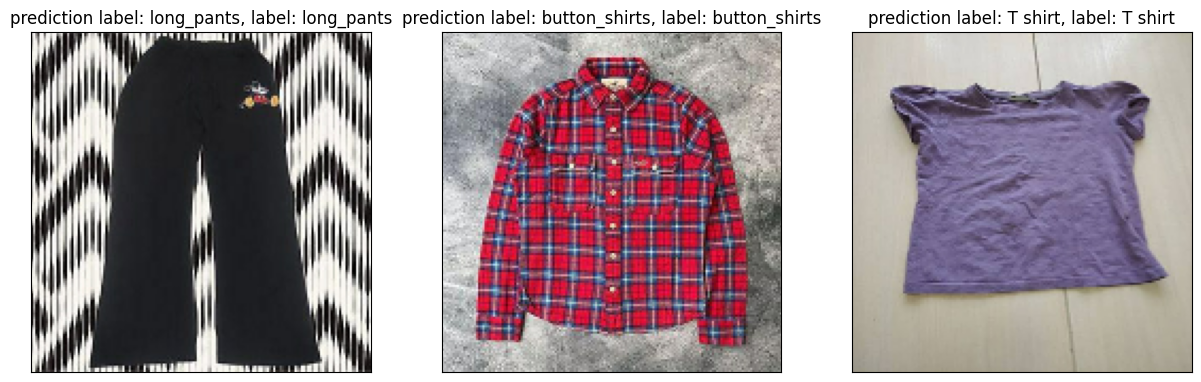

In [143]:
#make a prediction
for image_batch, label_batch in val_d.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(3):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'prediction label: {predicted_class[i]}, label: {class_names[label_batch[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [141]:
#save keras model
model_filepath = os.path.join(os.getcwd(),'models','model4.keras')
model.save(model_filepath, overwrite=True, zipped=None)